In [2]:
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
df.describe()

,fname,labels,is_valid
count,5011,5011,5011
unique,5011,473,2
top,000005.jpg,person,True
freq,1,408,2510


In [6]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [7]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [8]:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [9]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [10]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})

In [11]:
tmp_df

,a,b
0,1,3
1,2,4


In [12]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


In [13]:
dblock = DataBlock()

In [14]:
dsets = dblock.datasets(df)

In [15]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [16]:
dsets.items

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
...,...,...,...
5006,009954.jpg,horse person,True
5007,009955.jpg,boat,True
5008,009958.jpg,person bicycle,True
5009,009959.jpg,car,False


In [17]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [18]:
x['fname']

'008663.jpg'

In [19]:
dblock = DataBlock(get_x= lambda r: r['fname'], get_y= lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [20]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets[0]

('000005.jpg', 'chair')


We can see that the independent variable will need to be converted into a complete path, so that we can open it as an image, and the dependent variable will need to be split on the space character (which is the default for Python’s split function) so that it becomes a list:

In [57]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets[2]

(Path('/home/petewin/.fastai/data/pascal_2007/train/000009.jpg'),
 ['horse', 'person'])

In [58]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [59]:
dsets.train[0][1]

TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [60]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#3) ['bottle','diningtable','person']

In [61]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [62]:
df.index[df['is_valid']].to_list()

[0,
 1,
 2,
 4,
 6,
 7,
 8,
 10,
 12,
 18,
 19,
 22,
 25,
 26,
 27,
 28,
 30,
 32,
 34,
 38,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 61,
 62,
 63,
 69,
 70,
 71,
 73,
 76,
 77,
 83,
 84,
 85,
 89,
 90,
 91,
 94,
 100,
 102,
 104,
 105,
 106,
 107,
 108,
 111,
 113,
 116,
 117,
 118,
 120,
 121,
 123,
 124,
 125,
 126,
 128,
 130,
 134,
 135,
 136,
 137,
 138,
 142,
 144,
 147,
 148,
 149,
 150,
 151,
 154,
 158,
 160,
 161,
 162,
 164,
 165,
 167,
 169,
 171,
 172,
 173,
 177,
 178,
 181,
 185,
 186,
 188,
 189,
 195,
 197,
 201,
 204,
 205,
 206,
 207,
 208,
 209,
 212,
 213,
 215,
 216,
 218,
 221,
 222,
 223,
 224,
 226,
 233,
 234,
 235,
 237,
 239,
 240,
 241,
 243,
 244,
 245,
 246,
 249,
 250,
 251,
 252,
 256,
 258,
 263,
 264,
 267,
 269,
 271,
 278,
 279,
 282,
 283,
 284,
 286,
 289,
 292,
 293,
 294,
 296,
 298,
 300,
 301,
 305,
 306,
 310,
 311,
 312,
 314,
 316,
 318,
 319,
 320,
 321,
 324,
 325,
 326,
 328,
 329,
 331,
 334,
 335,
 3

In [63]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

In [64]:
dblock = DataBlock((ImageBlock, MultiCategoryBlock),
                    splitter=splitter,
                    get_x=get_x,
                    get_y=get_y)
                    
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [72]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter=splitter,
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

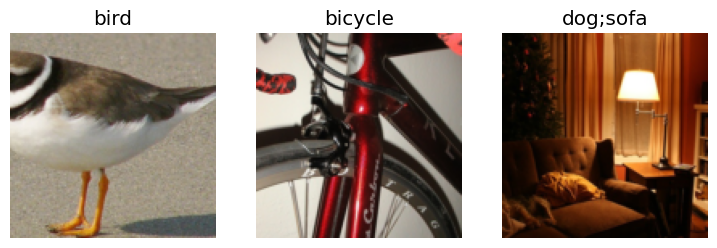

In [73]:
dls.show_batch(nrows=1, ncols=3)

In [76]:
dls.summary(get_x(df))

AttributeError: summary